In [40]:
import fastbox as fb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
import warnings
from ruamel.yaml.error import UnsafeLoaderWarning

# 忽略UnsafeLoaderWarning
warnings.simplefilter('ignore', UnsafeLoaderWarning)

# Liquidily of options

1、Trading volume relationship between options and underlying futures

In [57]:
id_lst = [ f'CU230{i+1}' for i in range(12)]
# 先研究id_lst[0]
CU2301_options = fb.data.futuresoptions.daily(instrumentid = id_lst[0])
CU2301_futures = fb.data.futures.daily(instrumentid = id_lst[0])
CU2301_options_vol = CU2301_options['vol'].groupby(level = 'date').sum()
# may exist some 
CU2301_options_vol.index=(CU2301_futures.delist_date.iloc[0]-CU2301_options_vol.index).days+1
CU2301_options_vol.name =  f'{id_lst[0]} options'
index0 = CU2301_options_vol.index.min()
CU2301_futures_vol = CU2301_futures.loc[:,'vol']
CU2301_futures_vol.name =  f'{id_lst[0]} futures' 
CU2301_futures_vol.index=(CU2301_futures.delist_date.iloc[0]-CU2301_futures_vol.index).days+1
CU2301_vol=pd.concat([CU2301_futures_vol,CU2301_options_vol],axis=1).sort_index()
CU2301_vol.loc[0,:]=0
CU2301_vol = CU2301_vol.sort_index().fillna(0)

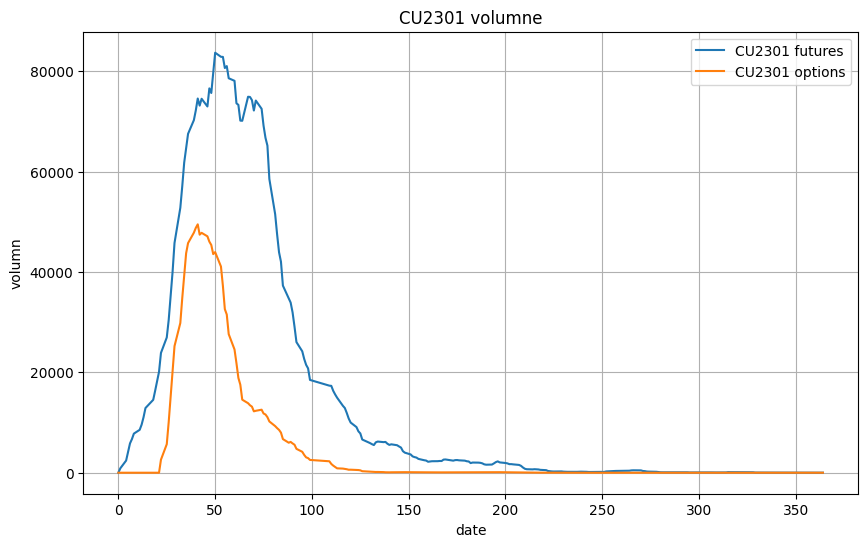

In [61]:
plt.figure(figsize=(10, 6))
smoothed = CU2301_vol.rolling(window=10,min_periods=0).mean()
plt.plot(smoothed, label=smoothed.columns)
plt.title("CU2301 volumne")
plt.xlabel('date')
plt.ylabel('volumn')

plt.legend()

plt.grid(True)

plt.show()

2、i want to get $\tau_1$ and $\tau_2$ (about a month),and the trading volume of options and futures accounts for the highest proportion of the total trading volume between $\tau_1$ and $\tau_2$

In [109]:
class total_liquid(object):
    def __init__(self,name):
        self.name = name
    def get_vol_data(self):
        _name = self.name
        options = fb.data.futuresoptions.daily(instrumentid = _name)
        futures = fb.data.futures.daily(instrumentid = _name)
        if options is None or futures is None:
            print('No data')
            return None
        else:
            options_vol = options['vol'].groupby(level = 'date').sum()
            options_vol.index=(futures.delist_date.iloc[0]-options_vol.index).days+1
            options_vol.name =  f'{_name} options'
            futures_vol = futures.loc[:,'vol']
            futures_vol.name =  f'{_name} futures' 
            futures_vol.index=(futures.delist_date.iloc[0]-futures_vol.index).days+1
            vol=pd.concat([futures_vol,options_vol],axis=1).sort_index()
            vol.loc[0,:]=0
            vol = vol.sort_index().fillna(0)     
            return vol
    def plot_one(self):
        _vol = self.get_vol_data()
        if _vol is None:
            pass
        else:
            plt.figure(figsize=(10, 6))
            smoothed = _vol.rolling(window=10,min_periods=0).mean()
            plt.plot(smoothed, label=smoothed.columns)
            plt.title(f"{self.name} volumne")
            plt.xlabel('date')
            plt.ylabel('volumn')
            plt.legend()
            plt.grid(True)
            plt.show()
    def plot_two(self):
        _vol = self.get_vol_data()
        _tau_lst = self.get_tau_two()
        if _vol is None:
            pass
        else:
            _tau1=_tau_lst[0]
            _tau2=_tau_lst[-1]
            smoothed = _vol.rolling(window=10,min_periods=0).mean()
            _min_vol = smoothed.min(axis=1)
            y = _min_vol.values
            x = np.array(_min_vol.index)

            plt.figure(figsize=(10, 6))
            plt.plot(smoothed, label=smoothed.columns)
            plt.fill_between(x, y, where=(x >= _tau1) & (x <= _tau2), color='gray', alpha=0.5)
            plt.title(f"{self.name} volumne")
            plt.xlabel('date')
            plt.ylabel('volumn')
            plt.legend()
            plt.grid(True)
            plt.show()            
    def get_tau_one(self):
        # in this way,i will let min(vol_option,vol_fulture) get the largest proportion between tau1 and tau2
        _vol = self.get_vol_data()
        if _vol is None:
            pass
        else:
            tau2 = _vol.min(axis=1).rolling(window=30,min_periods=1).sum().idxmax()
            tau_lst = _vol.loc[:tau2][-30:].index.tolist()
            tau1 = tau_lst[0]
            return tau_lst
    def get_tau_two(self):
        # in this way,i will let min(vol_option,vol_fulture) get the largest proportion between tau1 and tau2
        _vol = self.get_vol_data()
        tau2 = (_vol.rolling(window=30,min_periods=1).sum()/_vol.sum()).sum(axis=1).idxmax()
        tau_lst = _vol.loc[:tau2][-30:].index.tolist()
        tau1 = tau_lst[0]
        return tau_lst

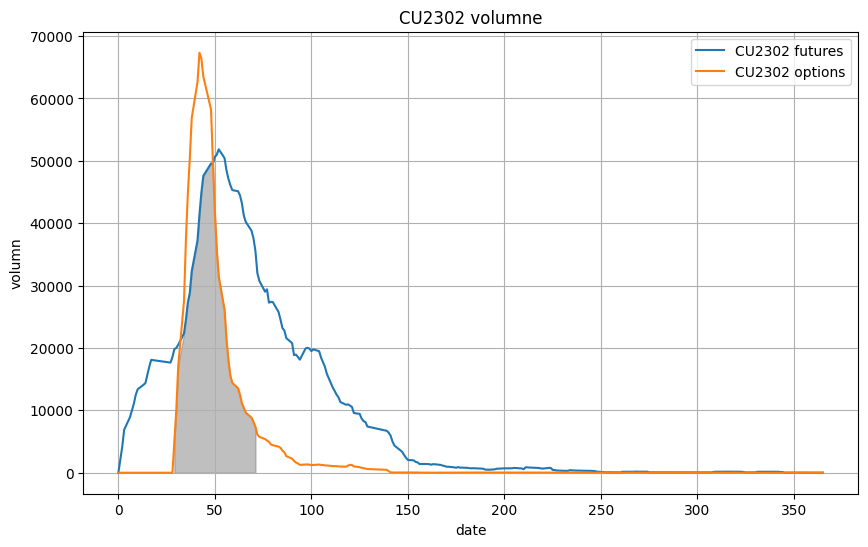

In [110]:
name = id_lst[1]
liquid = total_liquid(name)
liquid.plot_two()

In [ ]:
3.